## About
This program searches for cointegrated pairs, which can be useful for pairs trading strategy, using historical data of various instruments.

## Import modules

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

## Set the ticker symbols

In [2]:
tickers = ['^GSPC', '^IXIC', '^GDAXI', '^N100', '^N225', '^HSI', '^JKSE', 
           'ARKK', 'ARKG', 'ARKQ', 'ARKW', 'ETH-USD', 'BTC-USD', 'LTC-USD', 
           'GOOG', 'GOOGL', 'BRK-A', 'BRK-B']

## Download the historical data

#### Set start date and end date

In [3]:
start_date = datetime.now() - relativedelta(years=3)
start_date = start_date.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))

#### Fetch data from Yahoo Finance

In [4]:
df = yf.download(tickers, start=start_date, end=end_date)['Close']

[*********************100%***********************]  18 of 18 completed


#### Plot the source data

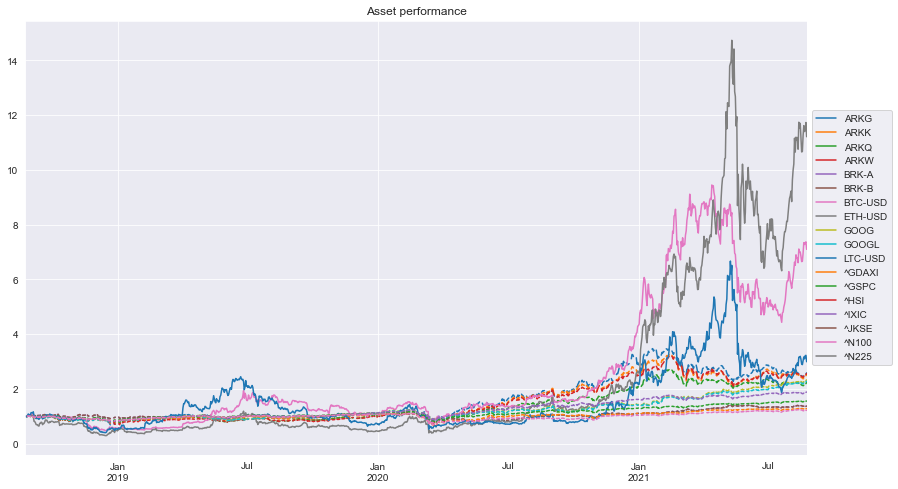

In [5]:
ax = (df/df.iloc[0]).plot(figsize=(14,8),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.set(xlabel='')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

## Optional: Create fake instruments that cointegrate with each other

In [6]:
returns = np.random.normal(0, 1, len(df))
df['FAKE-1'] = np.cumsum(returns) + 100
noise = np.random.exponential(2, len(df))
df['FAKE-2'] = df['FAKE-1'] - 15 + noise

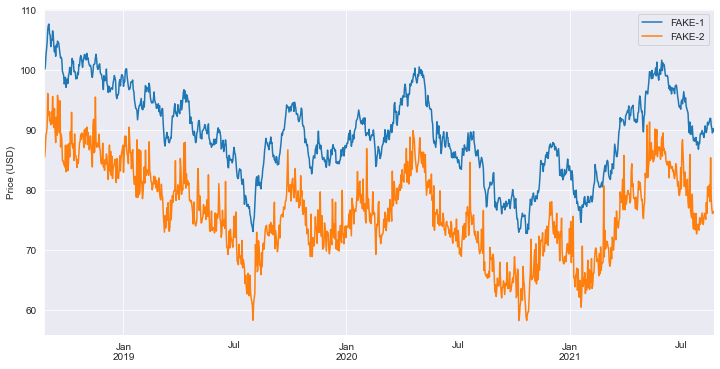

In [7]:
ax = df[['FAKE-1', 'FAKE-2']].plot(figsize=(12, 6))
ax.autoscale(tight=True, axis='x') 
ax.set(xlabel='', ylabel='Price (USD)');

#### Remove NaN values

In [8]:
df.dropna(inplace=True)
df.head(5)

,ARKG,ARKK,ARKQ,ARKW,BRK-A,BRK-B,BTC-USD,ETH-USD,GOOG,GOOGL,LTC-USD,^GDAXI,^GSPC,^HSI,^IXIC,^JKSE,^N100,^N225,FAKE-1,FAKE-2
Date,,,,,,,,,,,,,,,,,,,,
2018-08-27,32.950001,48.880001,37.169998,59.369999,316200.0,210.509995,6884.640137,285.602997,1241.819946,1256.270020,60.249901,12538.309570,2896.739990,28271.269531,8017.899902,6025.967773,1072.969971,22799.640625,102.276976,89.123748
2018-08-28,32.994999,48.990002,37.200001,59.439999,317124.0,210.770004,7096.279785,296.498993,1231.150024,1245.859985,63.024399,12527.419922,2897.520020,28351.619141,8030.040039,6042.649902,1073.329956,22813.470703,103.363857,89.575810
2018-08-29,33.702999,49.630001,37.369999,59.900002,317505.0,211.270004,7047.160156,289.312012,1249.300049,1264.650024,61.767200,12561.679688,2914.040039,28416.439453,8109.689941,6065.148926,1075.979980,22848.220703,104.618200,90.620092
2018-08-30,34.119999,49.599998,37.119999,59.290001,317000.0,209.750000,6978.229980,284.105011,1239.119995,1254.439941,60.315201,12494.240234,2901.129883,28164.050781,8088.359863,6018.963867,1071.339966,22869.500000,106.737881,96.103856
2018-08-31,34.450001,49.700001,37.139999,59.450001,315800.0,208.720001,7037.580078,283.003998,1218.189941,1231.800049,61.925499,12364.059570,2901.520020,27888.550781,8109.540039,6018.459961,1058.729980,22865.150391,107.461735,92.516741


## Search for cointegrated pairs

#### Define a  function to search for cointegrated pairs

In [9]:
def find_cointegrated_pairs(df, threshold=0.05):
    """
    Pass in a dataframe consists of stocks historical data, the threshold
    for pvalue, and returns the tscores, pvalues, and cointegrated pairs.
    """    
    # create matrices to store the scores and pvalues
    n = df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    tickers = df.columns
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            tick1 = df[tickers[i]]
            tick2 = df[tickers[j]]
            # use the function from statsmodel           
            result = coint(tick1, tick2)  
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            # store the pair if pvalue is less than the threshold
            if pvalue < threshold:
                pairs.append((tickers[i], tickers[j]))
    return score_matrix, pvalue_matrix, pairs

#### Define a function to perform the linear regression

In [10]:
def perform_linear_regression(x, y):    
    """
    Pass in two arrays and returns the linear regression coefficients and the fitting line.
    """ 
    # calculate the coefficients
    lm = LinearRegression().fit(x, y) 
    a = lm.intercept_
    beta = lm.coef_
    # create the fitting line
    xx = np.linspace(min(x), max(x),200) 
    yy = a + beta * xx
    return xx, yy, a, beta

#### Define a function to plot linear regression

In [11]:
def plot_linear_regression(x, y):
    """
    Pass in two arrays and performs the linear regression plot.
    """   
    x_, y_, a, beta = perform_linear_regression(x,y)
    plt.plot(x, y,'o', ms=2)
    plt.plot(x_,y_)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title('y = %f + %f*x'%(a, beta))
    plt.show()
    return a, beta

#### Define a function to confirm the stationarity

In [12]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

#### Find the cointegrated pairs

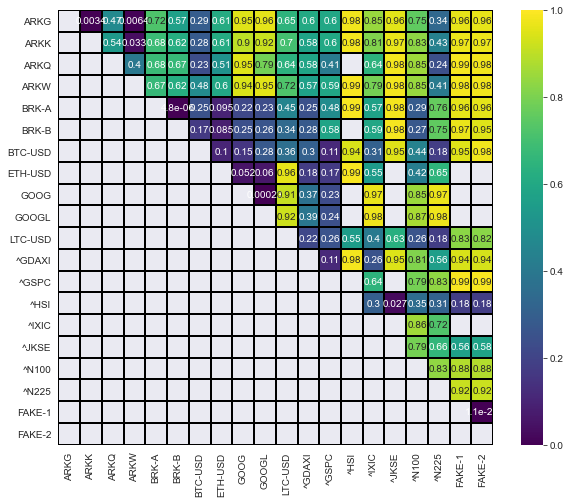

In [13]:
threshold = 0.04
scores, pvalues, pairs = find_cointegrated_pairs(df, threshold)

# create heat map
plt.figure(figsize=(10, 8))
sns.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, 
            cmap='viridis',annot=True, vmin=0, vmax=1, 
            center= 0.5, linewidths=1, linecolor='black', 
            mask=(pvalues >= 0.99), square=True);

In [14]:
pairs

[('ARKG', 'ARKK'),
 ('ARKG', 'ARKW'),
 ('ARKK', 'ARKW'),
 ('BRK-A', 'BRK-B'),
 ('GOOG', 'GOOGL'),
 ('^HSI', '^JKSE'),
 ('FAKE-1', 'FAKE-2')]

## Perform linear regression to obtain the coefficients for spread

--------------------------------------------------------
ARKG & ARKK


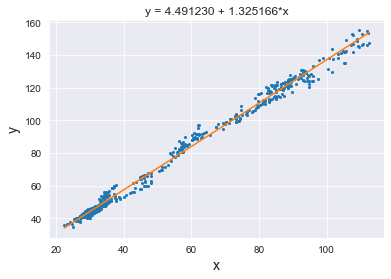

--------------------------------------------------------
ARKG & ARKW


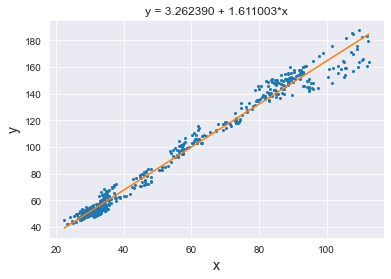

--------------------------------------------------------
ARKK & ARKW


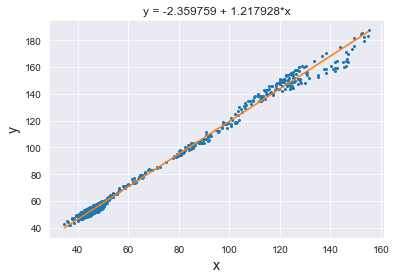

--------------------------------------------------------
BRK-A & BRK-B


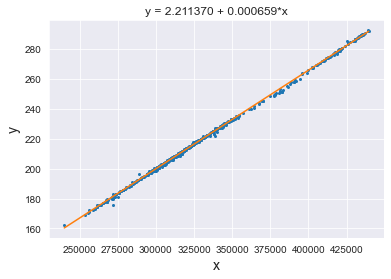

--------------------------------------------------------
GOOG & GOOGL


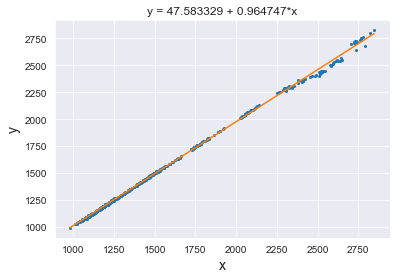

--------------------------------------------------------
^HSI & ^JKSE


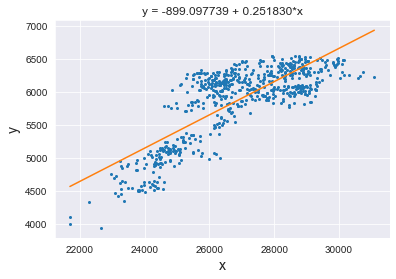

--------------------------------------------------------
FAKE-1 & FAKE-2


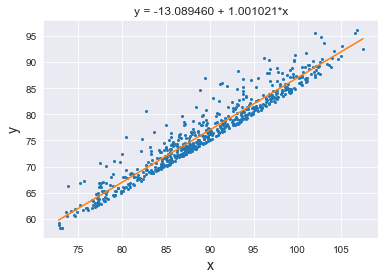

In [15]:
pairs_coeff = []
for x,y in pairs:
    print('--------------------------------------------------------')
    print(x + ' & ' + y)
    x_arr = np.array([df[x]]).T
    y_arr = np.array(df[y])
    a, beta = plot_linear_regression(x_arr, y_arr)
    pairs_coeff.append((a, beta[0]))

In [16]:
pairs_coeff

[(4.491230314539294, 1.3251660116316206),
 (3.262390356035638, 1.6110027126060507),
 (-2.359759432429186, 1.2179277485068205),
 (2.211370340228342, 0.000659016924549157),
 (47.58332910194713, 0.9647468387229992),
 (-899.0977387962612, 0.25183032341376455),
 (-13.08945992761798, 1.0010213451590704)]

## Plot the historical data and spread of each pair

--------------------------------------------------------
ARKG & ARKK


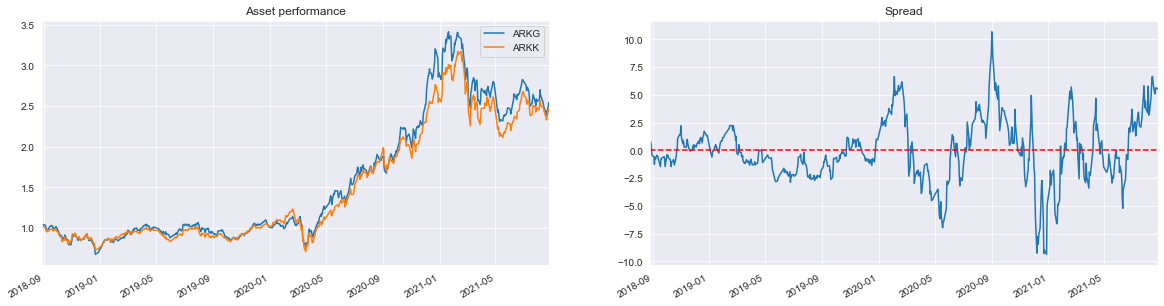

--------------------------------------------------------
ARKG & ARKW


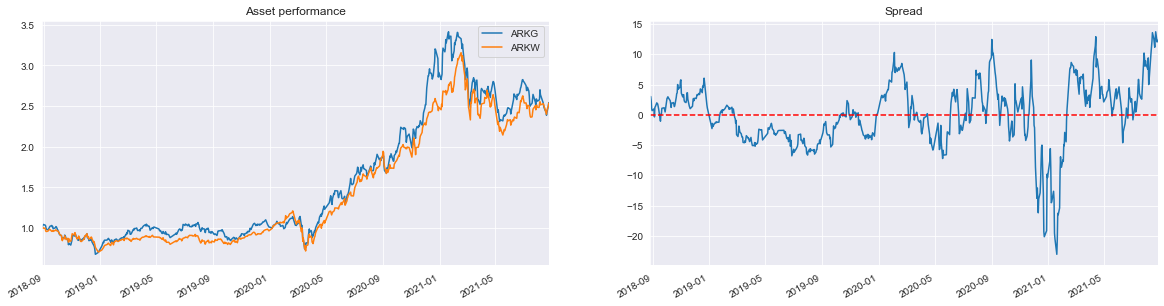

--------------------------------------------------------
ARKK & ARKW


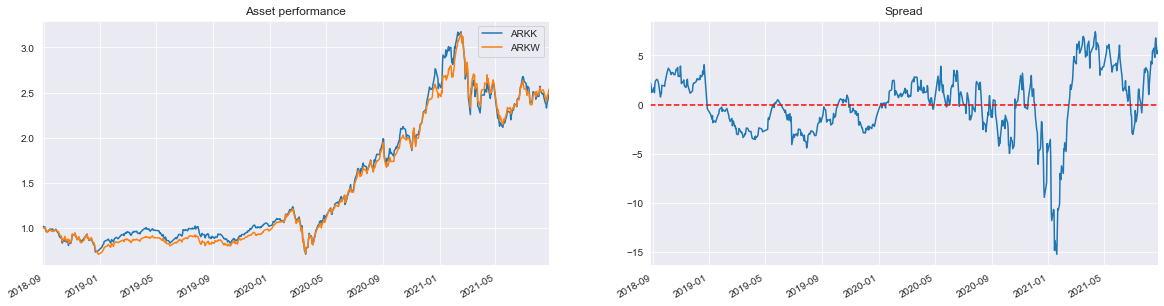

--------------------------------------------------------
BRK-A & BRK-B


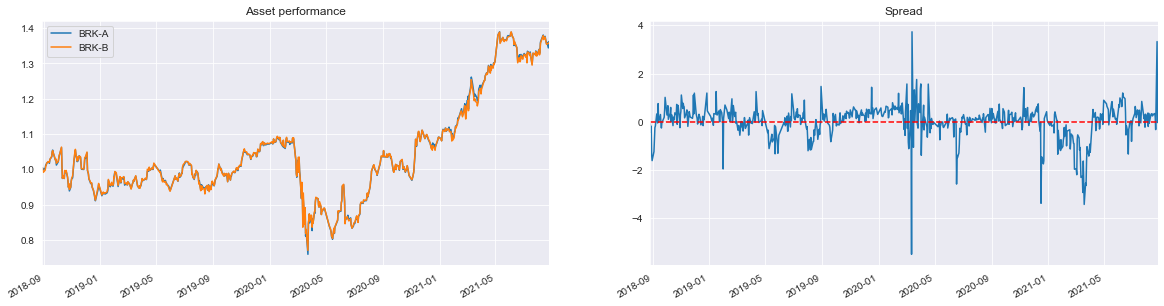

--------------------------------------------------------
GOOG & GOOGL


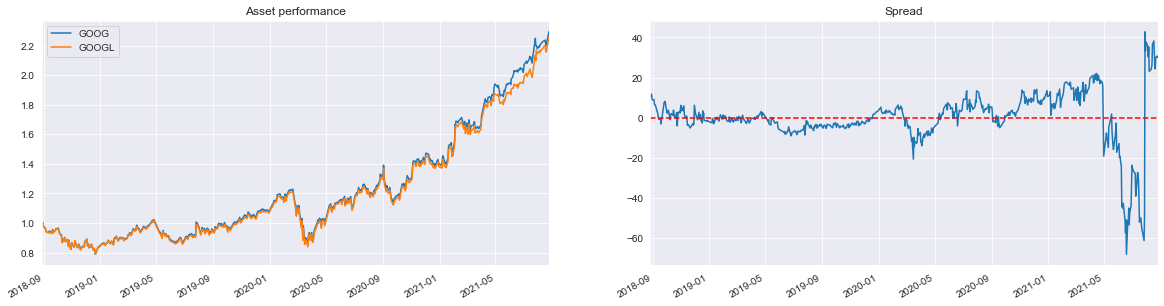

--------------------------------------------------------
^HSI & ^JKSE


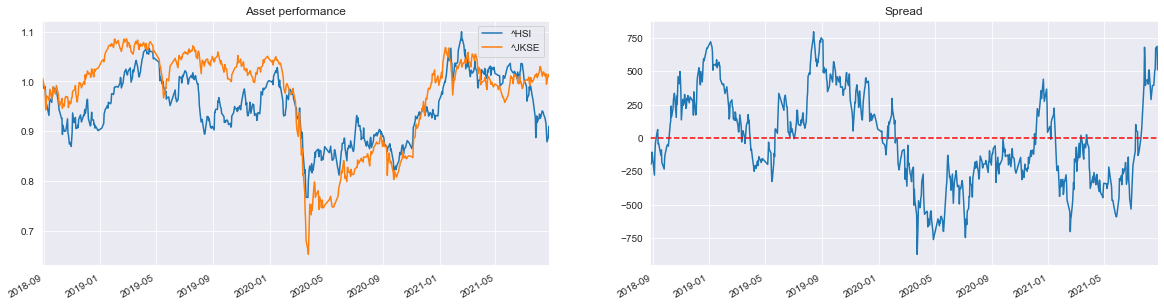

--------------------------------------------------------
FAKE-1 & FAKE-2


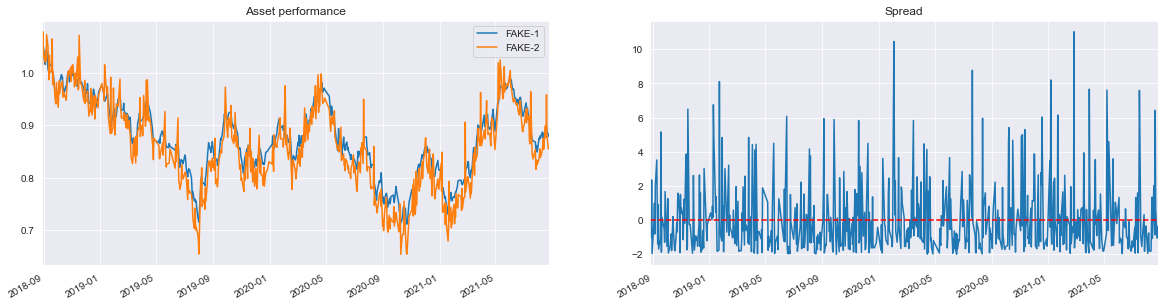

In [17]:
for (x, y), (a, beta) in zip(pairs, pairs_coeff):
    print('--------------------------------------------------------')
    print(x + ' & ' + y)
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    # historical performance
    (df[[x, y]]/df[[x, y]].iloc[0]).plot(title='Asset performance', ax=ax[0])
    # spread
    spread = df[y] - df[x]*beta - a
    spread.plot(title='Spread', ax=ax[1])
    ax[1].axhline(spread.mean(), color='red', linestyle='--')
    for i in range(2):
        ax[i].autoscale(tight=True, axis='x')
        ax[i].set(xlabel='')
    plt.show();

## Optional: Check the stationarity of each spread

In [18]:
for (x, y), (a, beta) in zip(pairs, pairs_coeff):
    print('--------------------------------------------------------')
    print(x + ' & ' + y + ' Spread')
    # spread
    spread = df[y] - df[x]*beta - a
    spread.plot(title='Spread', ax=ax[1])
    adf_test(spread)

--------------------------------------------------------
ARKG & ARKK Spread
Augmented Dickey-Fuller Test: 
ADF test statistic       -4.180694
p-value                   0.000710
# lags used               1.000000
# observations          628.000000
critical value (1%)      -3.440806
critical value (5%)      -2.866153
critical value (10%)     -2.569227
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
--------------------------------------------------------
ARKG & ARKW Spread
Augmented Dickey-Fuller Test: 
ADF test statistic       -3.946862
p-value                   0.001716
# lags used               1.000000
# observations          628.000000
critical value (1%)      -3.440806
critical value (5%)      -2.866153
critical value (10%)     -2.569227
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
--------------------------------------------------------
ARKK & ARKW Sprea